# Fetalnav - Infer and Evaluate

This notebook shows an example of a training session for the paper:

```bibtex
@inproceedings{toussaint.dlmia.18,
    author = {Toussaint, Nicolas and Khanal, Bishesh and Sinclair, Matthew and Gomez, Alberto and Skelton, Emily and Matthew, Jacqueline and Schnabel, Julia A.},
    title = {Weakly Supervised Localisation for Fetal Ultrasound Images},
    booktitle = {Proceedings of the 4th Workshop on Deep Learning in Medical Image Analysis},
    year = {2018}
}
```

## Requirements

* Cuda >= 8
* Python>=3.5
* PyTorch: `pip3 install torch==0.3.0 torchvision==0.2.1`
* Other Packages: [torchnet](https://github.com/pytorch/tnt), [spn](https://github.com/yeezhu/SPN.pytorch)
* [fetalnav](https://github.com/ntoussaint/fetalnav)

## Imports

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as torchtransforms

# models
import fetalnav
from fetalnav.models.spn_models import *

# transforms
from fetalnav.transforms import itk_transforms as itktransforms
from fetalnav.transforms import tensor_transforms as tensortransforms

# dataset
from fetalnav.datasets.itk_metadata_classification import ITKMetaDataClassification

# tensorboardX
from tensorboardX import SummaryWriter

from glob import glob as glob
from torch.autograd import Variable
from torch.nn import functional as F

import SimpleITK as sitk

import matplotlib.patheffects as path_effects

## Method Definitions

In [2]:


def define_transforms(hp):

    keys=('spacing', 'aspect_ratio', 'image_size','rescale_interval','flip')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    ## create transformation and data augmentation schemes

    # spacing is arbitrary
    resample = itktransforms.Resample(new_spacing=hp['spacing'])
    # transform an ITK image into a numpy array
    tonumpy = itktransforms.ToNumpy(outputtype='float')
    # transform a numpy array into a torch tensor
    totensor = torchtransforms.ToTensor()
    # crop to an aspect ratio
    crop = tensortransforms.CropToRatio(outputaspect=hp['aspect_ratio'])
    # padd to an aspect ratio
    padd = tensortransforms.PaddToRatio(outputaspect=hp['aspect_ratio'])
    # resize image to fixed size
    resize = tensortransforms.Resize(size=hp['image_size'], interp='bilinear')
    # rescale tensor to  interval
    rescale = tensortransforms.Rescale(interval=hp['rescale_interval'])
    # flip image in the y axis
    flip = tensortransforms.Flip(axis=2) if hp['flip'] else None

    # transforms to apply when learning
    train_transform = torchtransforms.Compose(
                        [resample,
                         tonumpy,
                         totensor,
                         crop,
                         resize,
                         rescale,
                         flip])

    # transforms to apply when validating
    val_transform = torchtransforms.Compose(
                            [resample,
                             tonumpy,
                             totensor,
                             crop,
                             resize,
                             rescale])

    hp['train_transform'] = train_transform
    hp['val_transform'] = val_transform

    return hp


def define_loaders(hp):

    keys=('datadir', 'train_transform','val_transform', 'batch_size', 'num_workers')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    datadir = hp['datadir']
    train_transform = hp['train_transform']
    val_transform = hp['val_transform']

    # load datasets
    train_dataset = ITKMetaDataClassification(root=datadir, mode='train',
                                              transform=train_transform)
    val_dataset   = ITKMetaDataClassification(root=datadir, mode='validate',
                                              transform=val_transform)

    # estimate the samples' weights
    train_cardinality = train_dataset.get_class_cardinality()
    val_cardinality = val_dataset.get_class_cardinality()
    train_sample_weights = torch.from_numpy(train_dataset.get_sample_weights())
    val_sample_weights = torch.from_numpy(val_dataset.get_sample_weights())

    print('')
    print('train-dataset: ')
    for idx, c in enumerate(train_dataset.get_classes()):
        print('{}: \t{}'.format(train_cardinality[idx], c))
    print('')
    print('validate-dataset: ')
    for idx, c in enumerate(val_dataset.get_classes()):
        print('{}: \t{}'.format(val_cardinality[idx], c))
    print('')

    # class labels
    classes_train = train_dataset.get_classes()
    classes_val = val_dataset.get_classes()

    assert(classes_train == classes_val), 'classes differ between train and validation sets'
    classes = classes_train
    del classes_train, classes_val

    # create samplers weighting samples according to the occurence of their respective class
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weights,
                                                                   int(np.min(train_cardinality)),
                                                                   replacement=True)

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=hp['batch_size'], shuffle=False,
                                               num_workers=hp['num_workers'], sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=hp['batch_size'], shuffle=False,
                                             num_workers=hp['num_workers'])

    hp['train_loader'] = train_loader
    hp['val_loader'] = val_loader

    hp['classes'] = classes

    return hp

def define_logging(hp):

    keys=('coordinate_system','arch', 'learning_rate', 'batch_size', 'aspect_ratio')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    # define output log directory
    p='cs={}-m={}-lr={}-bs={}-spn={}-aspect={}'.format(hp['coordinate_system'],
                                                       hp['arch'],
                                                       hp['learning_rate'],
                                                       hp['batch_size'],
                                                       1,
                                                       hp['aspect_ratio']
                                                      )
    p=os.path.join('logs', p)
    hp['save_model_path'] = p
    hp['Logger'] = SummaryWriter(log_dir=p)
    return hp

def define_model(hp):

    keys=('arch', 'classes', 'learning_rate', 'momentum', 'weight_decay')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    print('asking for model: {}'.format(hp['arch']))
    num_classes = len(hp['classes'])

    model = None

    if   hp['arch'] == 'resnet18':
        model = resnet18_sp(num_classes, num_maps=512, in_channels=1)
    elif hp['arch'] == 'resnet34':
        model = resnet34_sp(num_classes, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg13':
        model = vgg13_sp(num_classes, batch_norm=False, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg13_bn':
        model = vgg13_sp(num_classes, batch_norm=True, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg16':
        model = vgg16_sp(num_classes, batch_norm=False, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg16_bn':
        model = vgg16_sp(num_classes, batch_norm=True, num_maps=512, in_channels=1)
    elif hp['arch'] == 'alexnet':
        model = alexnet_sp(num_classes, num_maps=512, in_channels=1)

    print(model)

    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=hp['learning_rate'],
                                momentum=hp['momentum'],
                                weight_decay=hp['weight_decay'])
    hp['model'] = model
    hp['criterion'] = criterion
    hp['optimizer'] = optimizer

    return hp

def explore_dataset(hp):

    keys=('train_loader', 'classes', 'batch_size')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    train_loader = hp['train_loader']

    # show an image
    def imshow(img):
        npimg = img.numpy()
        return plt.imshow(np.transpose(npimg, (1, 2, 0)))

    dataiter = iter(train_loader)
    for i, (images, labels) in enumerate(train_loader):
        images, labels = dataiter.next()
        break
    # show a minibatch
    fig = plt.figure(0)
    fig.set_size_inches([15,4])
    imshow(torchvision.utils.make_grid([im for im in images]))
    plt.show()
    print('       '+'        '.join('%5s' % hp['classes'][np.argmax(labels[j].numpy())] for j in range(hp['batch_size'])))


def define_dictionaries(variables):
    engine_state = {
        'use_gpu': torch.cuda.is_available(),
        'evaluate': False,
        'start_epoch': 0,
        'max_epochs': 30,
        'epoch_step':[10,20],
        'maximize': True,
        'resume': None,
        'use_pb': True,
    }

    p = {
        'image_size': [224, 224],
        'spacing': [.5, .5, 1.],
        'flip': True,
        'rescale_interval': [0,1],
        'batch_size': 6,
        'num_workers': 8,
        'learning_rate': 0.01,
        'momentum': 0.9,
        'weight_decay': 5e-4,
        'arch': 'resnet18',
        'coordinate_system': 'cart',
        'aspect_ratio': 1.,
    }

    print('Initializing state...')
    p.update(engine_state)

    print('Updating variables...')
    p.update(variables)

    print('Defining transforms...')
    p = define_transforms(p)

    print('Defining dataset...')
    p = define_loaders(p)

    print('Defining model...')
    p = define_model(p)

    print('Defining logging...')
    p = define_logging(p)

    return p

def learning(hp):

    keys=('model', 'train_loader', 'val_loader', 'criterion', 'optimizer', 'save_model_path')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    model = hp['model']
    train_loader = hp['train_loader']
    val_loader = hp['val_loader']
    criterion = hp['criterion']
    optimizer = hp['optimizer']

    # instantiate a MultiLabelMAP engine
    engine = torchengine.MultiLabelMAPEngine(hp)
    print(hp['save_model_path'])
    # learn
    engine.learning(model, criterion, train_loader, val_loader, optimizer)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap


def hook_spn(model):

    # check if hooks already present 
    if hasattr(model, 'sp_hook') and hasattr(model, 'fc_hook'):
        return model
    # list soft proposal and fully conv layers
    sp_layers = []
    fc_layers = []
    for mod in model.modules():
        if isinstance(mod, SoftProposal):
            sp_layers.append(mod)
        elif isinstance(mod, torch.nn.Linear):
            fc_layers.append(mod)
    # make sure they are the same length
    assert len(sp_layers) == len(fc_layers), 'def hook_spn(model): sp layers and fc layers don\'t match'
    # initialise class response maps as a list of predetermied length
    model.class_response_maps = [None] * len(sp_layers)
    # define hooks
    def _sp_hook(self, input, output, idx=None):
        # hook the output of the soft proposal module
        self.parent_modules[0].class_response_maps[self.idx] = output
    def _fc_hook(self, input, output, idx=None):
        softproposal = self.parent_modules[0].class_response_maps[self.idx]
        # apply convolution of the output of the soft proposal with the classifier weights
        self.parent_modules[0].class_response_maps[self.idx] = F.conv2d(softproposal, self.weight.unsqueeze(-1).unsqueeze(-1))
    # iterate over the pairs of sp and fc
    for idx, (s, f) in enumerate(zip(sp_layers, fc_layers)):
        s.parent_modules = [model]
        f.parent_modules = [model]
        # indicate to the modules which ID they belong
        s.idx = idx
        f.idx = idx
        ## register hoooks
        model.sp_hook = s.register_forward_hook(_sp_hook)
        model.fc_hook = f.register_forward_hook(_fc_hook)
    return model

def generate_outputs(model, input):

    if input.ndimension() == 3:
        input = input.unsqueeze(0)
    assert input.size(0) == 1, 'Batch processing is currently not supported'
    # enable spn inference mode
    model = hook_spn(model)
    output = model(input)
    # predict scores
    scores = torch.nn.Sigmoid()(model(input)).data.cpu().squeeze()
    # instantiate maps
    maps = torch.stack(model.class_response_maps).squeeze(1)
    maps = F.interpolate(maps, size=(input.size(2), input.size(3)), mode='bilinear', align_corners=False).data.squeeze().cpu()
    return scores, maps

## Dictionary State Instance

In [3]:
datadir = os.path.join(os.path.dirname(fetalnav.__file__), 'data')
builtin_model_file = os.path.join(datadir, 'vgg11-sp-multiclassifiers.pth.tar')
modelfiles = [builtin_model_file,
              builtin_model_file]
classes = ['Abdomen', 'Background', 'Head', 'Limbs', 'Placenta', 'Spine', 'Thorax']

In [4]:
state = {'batch_size': 7,
         'max_epochs': 30,
         'image_size': [224] * 2,
         'evaluate': False,
         'resume': None,
         'learning_rate': 0.05,
         'epoch_step': range(0, 30, 5),
         'momentum': 0.6,
         'weight_decay':5e-4,
         'arch': 'resnet18',
         'save_model_path': '.',
         'coordinate_system':'pol',
         'aspect_ratio': 1.5,
         'spacing': [.5, .5, 1.],
         'flip': False,
         'rescale_interval': [0,1],
         'classes': classes
        }

state = define_transforms(state)


## Model definition

In [5]:
model = vgg11_sp(len(classes), num_maps=512, in_channels=1, batch_norm=True)

print(model)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(device)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model).cuda()
model.eval()


SPNetWSL(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, st

DataParallel(
  (module): SPNetWSL(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

## Models from Ensembling / image files to examine

In [6]:
files = glob('{}/*.mhd'.format(datadir))
files.sort()
files = iter(files)

## Explore model outputs

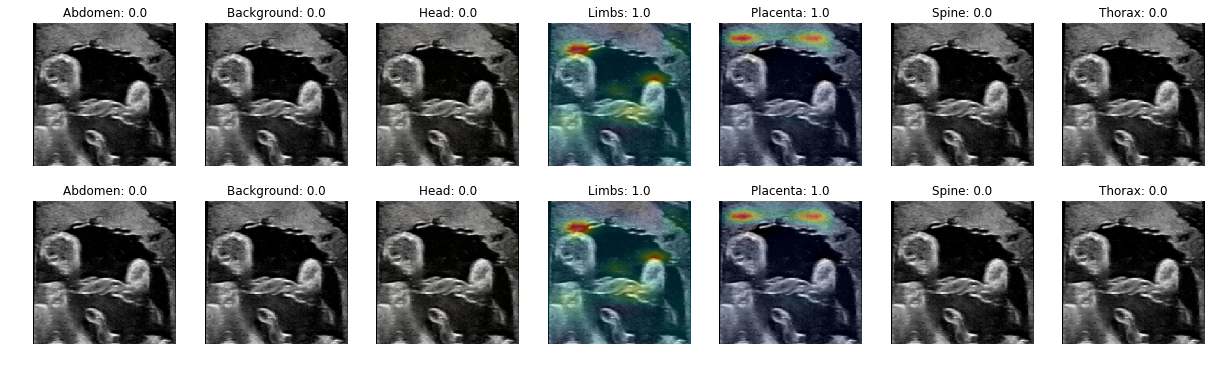

In [7]:
f=next(files)

inp = state['val_transform'](sitk.ReadImage(f)).unsqueeze(0)
vin = inp.float()
in_image = vin.data.numpy().squeeze()

fig, axes = plt.subplots(len(modelfiles), len(state['classes']))
fig.set_size_inches([3*len(state['classes']), 3*len(modelfiles)])
    
for idx, fn in enumerate(modelfiles):

    checkpoint = torch.load(fn)

    if torch.cuda.is_available():
        model.module.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint['state_dict'])
        
    sc, maps = generate_outputs(model, vin)    

    for cl in range(len(state['classes'])):
        response = maps[cl]
        ax = axes[idx, cl]
        ax.imshow(in_image, cmap='gray')
        alpha = sc[cl]
        if sc[cl] > 0.1:
            alpha=.7
        ax.imshow(response, cmap=transparent_cmap(plt.cm.jet), alpha=alpha)
        ax.axis('off')
        ax.set_title('{}: {:.1f}'.format(state['classes'][cl], sc[cl]))

plt.show()


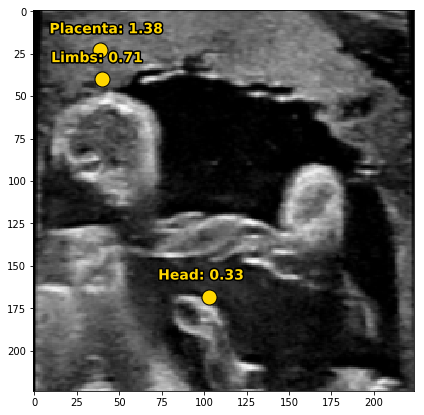

In [8]:
from spn.utils import localize_from_map
fig = plt.figure()
ax =fig.gca()
ax.imshow(in_image, cmap='gray')
for idx in range(len(state['classes'])):
    if sc[idx] > 0.01:
        detections = localize_from_map(maps[idx].numpy(), class_idx=0, location_type='point', threshold_ratio=1, multi_objects=False)
        _, x, y, s = detections[0]
        ax.plot(x, y, 'o', markerfacecolor='gold', markeredgecolor='black', ms=15)
        text = ax.text(x-30, y-10, '{}: {:.2f}'.format(state['classes'][idx], s), color='gold', fontsize=14, weight='bold')
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                               path_effects.Normal()])
fig.set_size_inches(7,7)


## About this notebook

written by Nicolas Toussaint

Contact: <nicolas.toussaint@gmail.com>